# Computational Methods in Economics

## Lecture 2 - Computer Arithmetic

In [ ]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import numpy as np
import math

import sys
from importlib import reload

## This Lecture

- [Introduction](#introduction)
- [Integers](#int)
- [Floating-Point Numbers](#floats)
- [Numerical Errors](#error)

----------------------------------------------------------------------------------------------------------------------

## Introduction

<a id = "introduction"></a>

Working with numbers and doing computations on a computer is inherently based on approximations. In other words, "exact" arithmetic and computer arithmetic does not always lead to the same result. Consider the example in Miranda and Fackler, p. 20:

In [3]:
print( 1e-20 + (1 - 1) )
print( (1e-20 + 1) - 1 )

1e-20
0.0


In case you are not familiar with the notation, $1\mathrm{e}{-20}$ is another way to write $1 \cdot 10^{-20}$. 

While the two expressions are mathematically equivalent and would return the correct result in exact arithmetic, only the first one is correctly evaluated. The result of the second expression, although close to the exact result, is incorrect.   

As a second example, consider the following subtraction:

In [4]:
print(1000000.2 - 1000000.1)

0.09999999997671694


In exact arithmetic, the result of this operation is 0.1. Evaluated numerically, we again see a small error. 

As a final example, consider the function $p(x) = (1 - x)^{10}$. Evaluating the multiplications, the *power series form* of this expression is

\begin{equation}
    p(x) = x^{10} - 10 x^9 + 45 x^8 - 120  x^7 + 210  x^6 - 252  x^5 + 210  x^4 - 120  x^3 + 45  x^2 - 10  x + 1  
\end{equation}

In exact arithmetic, these expressions are equivalent. If we use a computer to evaluate, say, the values between 0.99 and 1.01, we get the following:

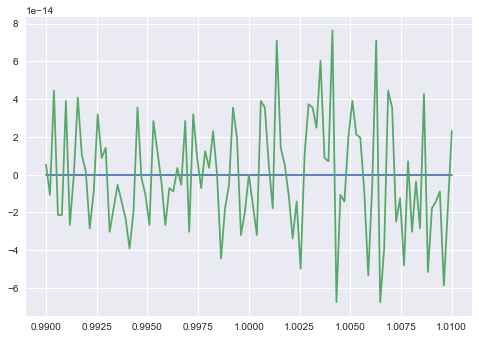

In [5]:
def fun(x):
    return (1 - x)**10

def fun2(x):
    return x**10 - 10 * x**9 + 45 * x**8 - 120 * x**7 + 210 * x**6 - 252 * x**5 + 210 * x**4 - 120 * x**3 + 45 * x**2 - 10 * x + 1  

x = np.linspace(0.99, 1.01, 103)

fig, ax = plt.subplots()
ax.plot(x, fun(x))
ax.plot(x, fun2(x))

Clearly, in exact arithmetic, the function $p$ has only one root, at $p(x) = 0$. However, its power series form exhibits multiple roots, while its functional values jump between positive and negative.

All these example illustrate the approximate nature of numerical computing. More precisely, they can be explained by the way that a computer represents numbers. 

----------------------------------------------------------------------------------------------------------------------

## Integers

<a id = "int"></a>

As outlined in the introductory Python sessions, we distinguish two types of numbers in numerical computing: *integers* and *floating point numbers (floats)*. We can use the **type** function to display a numer's type:

In [6]:
type(1)

int

In many programming languages, the number of bits used to represent an integer is limited. For example, say that an integer can be comprised by at most 1 byte, i.e. 8 bits (recall that a bit can take one of two values, 0 or 1). Then, only the numbers between 0 and 255 (the largest integer whose binary representation has 8 digits) can be represented. For larger integers, you would need a different type. 

In Python 3, however, this is not an issue: integers can be arbitrarily large (to the extent permitted by memory). 

As a reminder, a binary number is a sequence of $b_N b_{N-1} ... b_2 b_1 b_0$, where $b_j \in \{0, 1\}$, where

\begin{equation}
 y = b_N 2^N + b_{N-1} 2^{N-1} + ... + b_1 2^1 + b_0 2^0.
\end{equation}
For example, the binary number $1110$ is evaluated to
\begin{equation}
 y =  2^3 + 2^2 + 2^1 = 14.
\end{equation}

Python has a **bin** function that gives a binary representation (as a *string*) of integers. Note that the first two elements in the string (**'0b'**) just indicate that what follows is a binary number, and hence can be disregarded: 

In [7]:
bin(14)

'0b1110'

In [8]:
bin(255)

'0b11111111'

The other way round works as well: you can type a sequence of 0s and 1s (not as a string!), preceded by **0b**, and Python will return the corresponding integer:

In [9]:
0b101

5

Note that how an integer is represented is only loosely linked to how the integer *object* in Python is stored. For example, you could assume that it requires only 1 byte to store the integer 255. However, the function **getsizeof()** from the **sys** module shows that its size is actually *28* bytes: 

In [10]:
sys.getsizeof(255)

28

Recall that a Python object comprises more than only the value; other things that are stored in the object, for example information on the type.

For more information on how integers are stored in Python, compare https://stackoverflow.com/questions/23016610/why-do-ints-require-three-times-as-much-memory-in-python and http://mortada.net/can-integer-operations-overflow-in-python.html.

----------------------------------------------------------------------------------------------------------------------

## Floating-Point Numbers

<a id = "floats"></a>

Floating-point numbers (floats) are a subset of the real numbers. That they can only be a subset is intuitive: recall that there are infinitely many real numbers, while a computer can only deal with a finite set of representations.

### Representation: Idea

To understand how a computer deals with floating-point numbers, think of it the following way: each float $y$ is represented as 

\begin{equation}
    y = (-1)^s \cdot \tilde{f} \cdot 2^{\tilde{e}}
\end{equation}

where $\tilde{f}$, $\tilde{e}$ and $s \in \{0, 1\}$ are integers. It's those three integers that are *stored by the computer and used to represent the float.* 

Python has a method used on floats called **as_integer_ratio()** that returns two integers $n$ and $d$ such that

\begin{equation}
    y = \frac{n}{d} = \frac{(-1)^s \cdot \tilde{f}}{2^{-\tilde{e}}}
\end{equation}


In [11]:
n, d = (-3210.48).as_integer_ratio()

print(n)
print(d)

-7059920181484585
2199023255552


We can use this method, as well as Python's **int** conversion function, to write a function that takes a float and returns a three-element tuple consisting of $s$, $\tilde{e}$ and $\tilde{f}$.

In [12]:
def int_repr1(x):
    n, d = x.as_integer_ratio()
    s = int(n < 0)
    f = abs(n)
    e = -int( math.log(d)/math.log(2) )
    
    return s, e, f

print( int_repr1(-3210.48) )

(1, -41, 7059920181484585)


### Representation: IEEE Standard

There are different types of floating point numbers. In the following, we focus on 64-bit **double precision (DP)** floating point numbers, as defined by the *IEEE 754-1985 Standard for Binary Floating-Point Arithmetic*. As the name indicates, a DP number is stored using 64 bits. In contrast, **single precision (SP)** numbers have only 32 bits available. That said, the fundamental idea of how floats are stored and what that implies for numerical errors is analogous for SP and DP numbers.   



While the expression above captures the basic idea about how floats are represented, the actual implementation according to the "Standard" is slightly different:

\begin{equation}
    y = (-1)^s \cdot \left(1 + \frac{f}{2^{52}}\right) \cdot 2^{e - 1023}
\end{equation}

where $s$, $e$ and $f$ are integers. It is easy to see that this expression is equivalent to the one above for:

\begin{equation}
    f = \tilde{f} - 2^{52},\ e = \tilde{e} + 1075
\end{equation}


The 64 bits used to represent a DP float is divided between $s$, $e$ and $f$ in the following way:
- $s$ is either 0 or 1, i.e. 1 bit is used to store the value for $s$;
- $e$ is an 11-bit integer; since 2047 is the largest integer whose binary representation has 11 digits, we have 

\begin{equation}
0 \le e \le 2047
\end{equation}

For reasons omitted here, these inequalities are actually strict: $0 < e < 2047$.

- $f$ is a 52-bit integer; since $2^{52} - 1$ is the the largest integer whose binary representation has 52 digits, we have

\begin{equation}
0 \le f \le 2^{52} - 1
\end{equation}

In [13]:
len(bin(2047)[2:])

11

In [14]:
len(bin(2**52 - 1)[2:])

52

### Some useful functions

Before moving on, it will be useful to define a function **comp_float** that takes a tuple consisting of $s$, $e$ and $f$ and computes the resulting floating point number:

In [15]:
def comp_float(tup):
    """
    Takes a tuple consisting of s, e and f and computes the resulting DP floating point number, according to the IEEE formula
    """
    s, e, f = tup
    
    return (-1)**s * (1 + f * 2**(-52) ) * 2**(-1023 + e)

The following function implements going in the other direction: it takes a floating point number $x$ and decomposes it 
into the tuple consisting of $s$, $e$ and $f$. Don't worry about the exact implementation here.

In [16]:
def int_repr2(x):
    """
    Takes a floating point number $x$ and decomposes it in the tuple consisting of $s$, $e$ and $f$
    """
    n, d = x.as_integer_ratio()
    s = int(n < 0)
    
    n = abs(n)
    
    while n > 2 - 2**(-52):
        n *= 0.5
        d *= 0.5
        
    f = int( (n - 1) * 2**52 )
    e = 1023 + int( math.log(1/d)/math.log(2) )
    
    return s, e, f

    
s, e, f = int_repr2(-3210.48)
print( s, e, f )
print( comp_float( (s, e, f) ) )

1 1034 2556320554114089
-3210.48


We can also use the function **int_repr2** in another function **float_to_bin** that takes a float and translates it into its binary computer representation:

In [17]:
def float_to_bin(x):
    s, e, f = int_repr2(x)
    return "{} {:011b} {:052b}".format(s, e, f)

print( float_to_bin(-3210.48) )

1 10000001010 1001000101001111010111000010100011110101110000101001


----------------------------------------------------------------------------------------------------------------------

## Where do numerical errors come from?


<a id = "errors"></a>

The key limitation when using real numbers on a computer was already hinted to above, and becomes obvious when looking at the representation described above: there are infinitely many real numbers, while there is only a *finite combination* of possible significands and exponents - recall that both $e$ and $f$ are required to be integers, and are bounded below and above. Hence, the set of DP numbers is finite. 

As a result, working with floating point numbers is inherently *approximate*. The following section illustrate the main issue and consequences for numerical analysis. 

#### Issue 1: Not all floats are DP numbers

First, following directly from the inherently finite set of DP numbers, not all floats are DP numbers. For example, the number 1000000.1 is a floating point number, but it is actually not a DP number: it is approximated by the DP number 1000000.09999999997671693563. In other words, both 1000000.1 and 1000000.09999999997671693563 (and in fact all numbers in between) have the same representation on a computer.

In [18]:
format(1000000.1, '.20f')

'1000000.09999999997671693563'

In [19]:
int_repr2(1000000.1)

(0, 1042, 4086335823622963)

In [20]:
int_repr2(1000000.09999999997671693563)

(0, 1042, 4086335823622963)

#### Machine epsilon

This issue is related to the the so-called **machine epsilon** (or **machine zero**) $\epsilon_{DP}$ which is defined as the distance from 1 to the next larger number that the computer can represent as a distinct float. In double precision, it turns out to be $2^{-52}$, which can be seen using the expression above: 

\begin{equation}
    y = (-1)^s \cdot \left(1 + \frac{f}{2^{52}}\right) \cdot 2^{e - 1023}
\end{equation}

Note that 1.0 can be represented by the tuple $s = 0$, $f = 0$ and $e = 1023$:


In [21]:
int_repr2(1.0)

(0, 1023, 0)

Next, it is easy to verify that the float $1 + 2^{-52}$ can be represented by $s = 0$, $f = 1$ and $e = 1023$:

In [22]:
int_repr2(1 + 2**(-52))

(0, 1023, 1)

What about the (smaller) float $1 + 2^{-53}$? In the expression above, the combination $s = 0$, $f = 0.5$ and $e = 1023$ would do the trick. However, recall that $f$ must be an integer. Hence, applying the usual decomposition on $1 + 2^{-53}$ shows that it is represented *in the same way* as 1.0:

In [23]:
int_repr2(1 + 2**(-53))

(0, 1023, 0)

Note that in general, the distance between two adjacent DP numbers is increasing in their exponent. You will show in this week's problem set that for two adjacent DP numbers $y_1$ and $y_2$ with $y_1 < y_2$, 

\begin{equation}
   | y_2 - y_1 | = \epsilon_{DP} 2^{e(y_1) - 1023} \equiv ulp(y_1) 
\end{equation}

The expression on the RHS is often referred to as the *ulp* ("units in last place") of a DP number.   

Hence we can conclude that it is not possible for a computer to distinguish two floats whose distance is less than $2^{-52}$ in double precision: 

In [24]:
eps = 2**(-52) 
print(eps)

2.220446049250313e-16


Note that this feature explains our motivating example above:

In [25]:
print( (1e-20 + 1) - 1 )

0.0


Since

In [26]:
1e-20 < eps

True

The sum $(1\mathrm{e}{-20}+ 1)$ is not distinguishable from 1, and hence the result of the subtraction is zero.

As a final point, note that - perhaps somewhat confusing - machine zero is *not* the smallest float that can be represented on a computer. This is given by the smallest values for $e$ (1) and $f$ (0), which results in:

In [27]:
2**(-1022)

2.2250738585072014e-308

In [28]:
int_repr2(2**(-1022))

(0, 1, 0)

Similarly, the largest float that can be represented is given by $e = 2046$ and $f = 2^{52} - 1$:

In [29]:
print( comp_float((0, 2046, 2**52-1)) )

1.7976931348623157e+308


In [30]:
## the following throws an error due to overflow
# print(int_repr2(1.7976931348623159e+308))

Finally, in Python, the **sys.float_info** function summarizes machine epsilon, as well as the max and the min:

In [31]:
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

#### Issue 2: The set of DP numbers is not closed under the arithmetic operations

Even if two floats are both DP numbers, applying arithmetic operations (addition, subtraction, multiplication, division) on them does not necessarily yield a DP number as a result. In other words, the set of DP numbers is not closed under these operations. As an example consider $y_1 = 2^{52} - 1$ and $y_2 = 2^{52} + 1$. Using the formula above, it is easy to show that these integers, when interpreted as floats, are DP numbers.

In [32]:
## cp. example in class
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

We can verify the representation by using our function above:

In [33]:
int_repr2(float(2**52 - 1))

(0, 1074, 4503599627370494)

In [34]:
int_repr2(float(2**52 + 1))

(0, 1075, 1)

Next, the product of these two DP numbers gives $y_1 y_2 = 2^{104} - 1$. We could show analytically that this is not a DP number, but let's skip this here. Instead, there is a simple way of checking if the *floating point representation of an integer* is a DP number, using the **float** conversion function:

In [35]:
float( 2**104 - 1 ) == 2**104 - 1

False

Hence, $2^{104} - 1$ is not a DP number. In fact, the representation of $2^{104} - 1$ is the same as for $2^{104}$, which is a DP number.

In [36]:
int_repr2(float(2**104 - 1))

(0, 1127, 0)

In [37]:
int_repr2(float(2**104))

(0, 1127, 0)

In [38]:
float(2**104) == 2**104

True

#### Quality of Approximation

The examples above have shown that a computer *approximates a real number $z$ that is not a DP number (e.g. $2^{104} - 1$) by the DP number closest to $z$ (e.g. $2^{104}$)*. In the following, I denote this approximation by $z_{DP}$. The difference between $z$ and $z_{DP}$ is referred to as *roundoff error*.

Similarly, the value of a sum, difference, product or quotient of DP numbers is equal to the DP number closest to the precise result, e.g.

\begin{equation}
   y_1 + y_2 \approx (y_1 + y_2)_{DP} 
\end{equation}

It can be shown (omitted here, but feel free to verify) that 

\begin{equation}
    |\mu| \equiv \left| \frac{z_{DP} - z}{z} \right| \le \frac{1}{2} \epsilon_{DP}
\end{equation}

In words, *the absolute relative error in the DP approximation $z_{DP}$ to the real number $z$ is at most half machine epsilon*. 

What does this mean in practice? Recall that $\epsilon_{DP} = 2^{-52} \approx 2\mathrm{e}{-16}$. Hence, the absolute relative error is bounded above by about $1\mathrm{e}{-16}$. Moreover, rearranging 

\begin{equation}
    \left| z_{DP} - z \right| \le \frac{1}{2} |z| \cdot 2 \cdot 10^{-16} \le \frac{1}{2} |z|  \cdot 10^{-15}.
\end{equation}

This last expression implies that $z_{DP}$ is about 15-digits accurate as an approximation to $z$. Very loosely speaking, this means that the first 15 significant digits are the same.

Related to this is the following observation: adding or subtracting two floats whose relative magnitudes differ by more than machine epsilon (or, equivalently, **by more than the number of significant digits**) is not meaningful in the sense that the smaller value is effectively treated as zero. Formally, let $z$ be a DP number and let $y$ be a float such that

\begin{equation}
    \frac{y}{z} = r.
\end{equation}

In the following, we show that we get $ (z + y)_{DP} > z $ only if
\begin{equation}
    r \ge \epsilon_{DP}
\end{equation}

In [39]:
## cp. example in class
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

Note that $\epsilon_{DP}$ is an upper bound on $r$: in some cases (when $f(z) > 1$), adding a number of smaller magnitude still results in a distinct DP number.

In [40]:
int_repr2(0.6)

(0, 1022, 900719925474099)

In [41]:
int_repr2(0.6 + 0.6 * 2**(-53))

(0, 1022, 900719925474100)

#### Propagation of Errors

To summarize what's outlined above, when working with floating point numbers, there are two sources of error:
- the error inherent in a float $z$ if $z$ is not a DP number
- the error introduced when an arithmetic operation is performed on two DP numbers $y_1$ and $y_2$ 


Given the bound on the absolute relative approximation error, we can write 

\begin{equation}
    z_{DP} = (1 + \mu) z , \ \  \text{with}\ \ |\mu| \le \frac{1}{2} \epsilon_{DP}
\end{equation}

Moreover, suppose we perform an arithmetic operation on two DP numbers $y_1$ and $y_2$. As outlined above, the result is not in general a DP number, but instead is approximated by $(y_1 + y_2)_{DP}$. For the example of addition,

\begin{equation}
   (y_1 + y_2)_{DP} = (1 + \mu_A) (y_1 + y_2), \ \  \text{with}\ \ |\mu_A| \le \frac{1}{2} \epsilon_{DP}
\end{equation}

Analogous expression can be derived for the other arithmetic operations.  

Hence, what happens if we perform an arithmetic operation on two floats $z_1$ and $z_2$  that are not DP numbers? With

\begin{equation}
    (z_1)_{DP} = (1 + \mu_1) z_1 ,\ \ (z_2)_{DP} = (1 + \mu_2) z_2
\end{equation}

we get

\begin{equation}
\begin{split}
   \left[(z_1)_{DP} + (z_2)_{DP}\right]_{DP} &= (1 + \mu_A) \left[(z_1)_{DP} + (z_2)_{DP}\right] \\
   &= (1 + \mu_A) \left[(1 + \mu_1) z_1 + (1 + \mu_2) z_2 \right]
\end{split}
\end{equation}

Again, similar expressions can be derived for the other arithmetic operations.  

Usually, numerical analysis involves a large number of operations on floating point numbers. The derivation above illustrates that the approximation error in the final result (compared to exact arithmetic) is the accumulation of errors from all the arithmetic operations, on top of the errors in the initial numbers (e.g. parameters). 

This propagation of errors when using floating-point arithmetic also explains why it is better to use double-precision numbers than single-precision numbers. While the same formal arguments can be made for SP arithmetic, the relative errors $\mu$ (and hence the overall error in the final result) are (much) smaller for DP numbers.

----------------------------------------------------------------------------------------------------------------------

As a final comment, note that the actual size of an object representing a floating point number in Python is greater than 64 bit (8 byte). In fact, *all* floating point numbers, independent of their size, are stored using 24 bytes. This leads to the somewhat curious situation that the largest floating point number needs less space than the smallest integer. 

In [42]:
sys.getsizeof(1.0)

24

In [43]:
sys.getsizeof(1.7976931348623157e+308)

24

In [44]:
sys.getsizeof(1)

28

More information on floats in Python:
- https://docs.python.org/3/tutorial/floatingpoint.html
- https://stackoverflow.com/questions/4838994/float-to-binary

----------------------------------------------------------------------------------------------------------------------